In [ ]:
!pip install xgboost
!pip install imblearn
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train.csv')
X_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test.csv')
y_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train.csv')
y_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test.csv')

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910786 entries, 0 to 1910785
Data columns (total 20 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   CANALE_PROV                 float64
 1   SIT ASSUN                   float64
 2   AMT_PREMIO_CTTO             float64
 3   AMT_PREMIO_RCA              float64
 4   GAR_INFORTUNI_MALATTIA      float64
 5   FIGLI                       float64
 6   ANZIANITA_ATTIVA            float64
 7   COD_TIPO_ALIMENTAZIONE      float64
 8   RATING                      float64
 9   n. of total contracts       float64
 10  GAR_BONUS_PROTECTION        float64
 11  AMT_SCONTO_CTTO             float64
 12  SCONTO_TOT_RCA              float64
 13  MODALITA_PAGAMENTO_STIPULA  float64
 14  RAGG_BUSINESS               float64
 15  NUM_RATE                    float64
 16  GAR_INCFURTO                float64
 17  SUM_IMP_PREMIO_CTTO         float64
 18  GAR_VANDALICI               float64
 19  GAR_KASKO_MINIKASKO  

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273710 entries, 0 to 273709
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CANALE_PROV                 273710 non-null  float64
 1   SIT ASSUN                   273710 non-null  float64
 2   AMT_PREMIO_CTTO             273710 non-null  float64
 3   AMT_PREMIO_RCA              273710 non-null  float64
 4   GAR_INFORTUNI_MALATTIA      273710 non-null  float64
 5   FIGLI                       273710 non-null  float64
 6   ANZIANITA_ATTIVA            273710 non-null  float64
 7   COD_TIPO_ALIMENTAZIONE      273710 non-null  float64
 8   RATING                      273710 non-null  float64
 9   n. of total contracts       273710 non-null  float64
 10  GAR_BONUS_PROTECTION        273710 non-null  float64
 11  AMT_SCONTO_CTTO             273710 non-null  float64
 12  SCONTO_TOT_RCA              273710 non-null  float64
 13  MODALITA_PAGAM

In [ ]:
columns_to_drop= ['SCONTO_TOT_RCA', 'AMT_PREMIO_RCA']
X_train=X_train.drop(columns_to_drop, axis=1)
X_test=X_test .drop(columns_to_drop, axis=1)

SPLIT

In [ ]:
# --- 📦 Imports & Utility Functions ---
def plot_roc_and_pr_curves(y_test, y_proba, model_name):
    if y_proba is None:
        print(f"\u26a0\ufe0f No probability estimates for {model_name}. Skipping ROC/PR curves.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color="blue", lw=2, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 100)
    f1_scores = [f1_score(y_true, y_proba >= t) for t in thresholds]
    best_index = np.argmax(f1_scores)
    return thresholds[best_index], f1_scores[best_index]

***IF WE SPLIT BY TIME, THE DISTRIBUTION OF THE TARGET FEATURE IS DIFFERENT BETWEEN TRAIN AND TEST SET. SO I WOULD SUGGEST TO PRESERVE THE Y DISTRIBUTION RATHER THAN PRIORITIZE SPLITTING BY TIME.OTHERWISE, PERFORMANCE WILL BE HEAVILY AFFECTED***

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier # Import the XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score # Import accuracy_score
from sklearn.metrics import confusion_matrix # Import confusion_matrix

In [ ]:
# --- ⚙️ Model Definitions ---
'''param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight='balanced'),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20]
        }
    },
    "XGBoost": {
        "model": XGBClassifier( use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50],
            "learning_rate": [0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced'),
        "params": {
            "n_estimators": [50],
            "max_depth": [3, 5],
            "min_samples_split": [3],
            "n_jobs": [-1]
        }
    }
}'''

'param_grids = {\n    "Logistic Regression": {\n        "model": LogisticRegression(max_iter=1000, class_weight=\'balanced\'),\n        "params": {\n            "C": [0.01, 0.1, 1, 10],\n            "solver": ["liblinear"]\n        }\n    },\n    "Decision Tree": {\n        "model": DecisionTreeClassifier(class_weight=\'balanced\'),\n        "params": {\n            "criterion": ["gini", "entropy"],\n            "max_depth": [None, 10, 20]\n        }\n    },\n    "XGBoost": {\n        "model": XGBClassifier( use_label_encoder=False, eval_metric=\'logloss\'),\n        "params": {\n            "n_estimators": [50, 100],\n            "learning_rate": [0.01, 0.1, 0.2],\n            "max_depth": [3, 5]\n        }\n    },\n    "Gradient Boosting": {\n        "model": GradientBoostingClassifier(),\n        "params": {\n            "n_estimators": [50],\n            "learning_rate": [0.1, 0.2],\n            "max_depth": [3, 5]\n        }\n    },\n    "Random Forest": {\n        "model": Random

In [ ]:
'''# --- ⚙️ Model Definitions ---
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight='balanced'),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 10, 20]
        }
    }
  }'''

In [ ]:
# --- ⚙️ Model Definitions ---
param_grids = {
    "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=6.85, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "min_samples_leaf": [2, 5],
            "n_estimators": [50,100],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced'),
        "params": {
            "n_estimators": [50],
            "max_depth": [3, 5],
            "min_samples_split": [3],
            "n_jobs": [-1]
        }
    }
}

In [ ]:
'''# --- ⚙️ Model Definitions ---
param_grids = {

        "XGBoost": {
        "model": XGBClassifier(scale_pos_weight=6.85, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    }
}'''

'# --- ⚙️ Model Definitions ---\nparam_grids = {\n\n        "XGBoost": {\n        "model": XGBClassifier(scale_pos_weight=6.85, use_label_encoder=False, eval_metric=\'logloss\'),\n        "params": {\n            "n_estimators": [50, 100],\n            "learning_rate": [0.01, 0.1, 0.2],\n            "max_depth": [3, 5]\n        }\n    }\n}'

***🔧 Hyperparameter tuning (with F1 focus)***

***📊 Prints all important metrics***

***🧠 Stores best models in a dictionary***

***📉 Automatically handles binary imbalance***

***🖼️ Displays 3 visuals: Confusion Matrix, ROC, PR Curve***


🔍 Performing Grid Search for XGBoost...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Accuracy:  0.505
Precision: 0.202
Recall:    0.980
F1 Score:  0.335
ROC AUC:   0.852


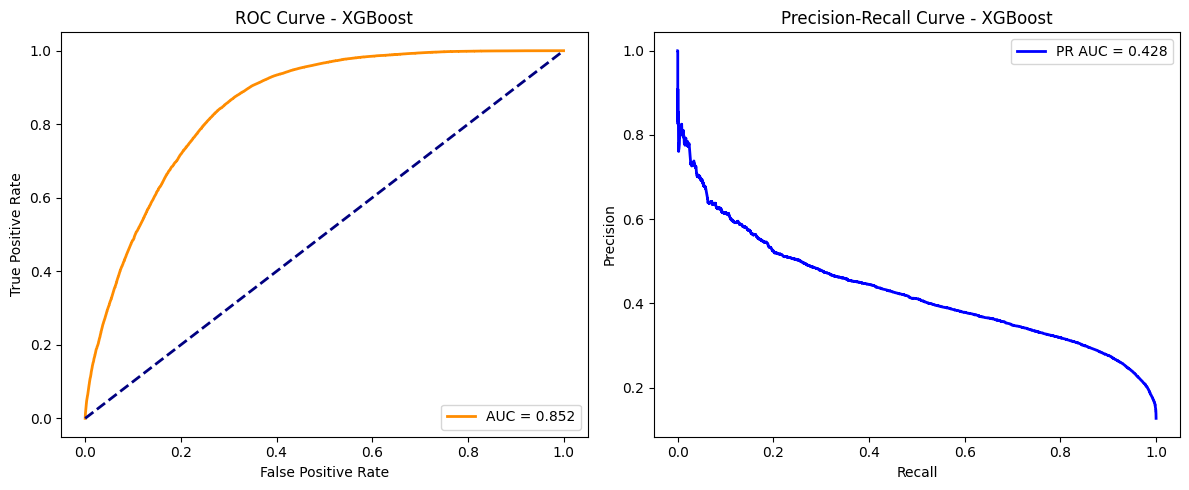

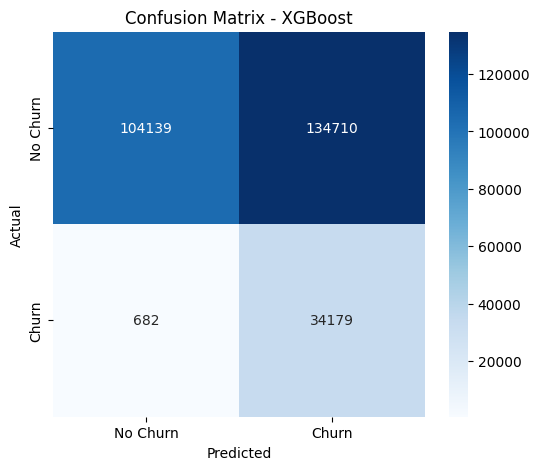


🔍 Performing Grid Search for Gradient Boosting...



/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# --- 🔁 Training & Evaluation ---
best_models = {}

for name, mp in param_grids.items():
    print(f"\n\U0001f50d Performing Grid Search for {name}...\n")

    grid_search = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        cv=5,
        scoring={  # Multiple metrics for evaluation
            'accuracy': 'accuracy',
            'f1': 'f1',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': 'roc_auc'
        },
        refit='f1',  # Best model will be selected based on f1 score
        n_jobs=-1
    )

    # Fit the grid search with the resampled data
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    print(f"\u2705 Best Parameters for {name}: {grid_search.best_params_}")

    # Make predictions and calculate metrics
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Output performance metrics
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
        plot_roc_and_pr_curves(y_test, y_proba, name)  # Ensure this function is defined

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
feature_names = X_train.columns # Changed from X_test.columns to X_train_selected.columns
# Inspect Coefficients or Feature Importances
for name, best_model in best_models.items():
    print(f"\n🔍 Inspecting {name}...\n")
# For Logistic Regression
    if isinstance(best_model, LogisticRegression):
        print(f"Coefficients for {name}:")
        coef = best_model.coef_.ravel()  # Flatten the coefficients array (in case of binary classification)
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,  # Replace 'feature_names' with the list of actual feature names
            'Coefficient': coef
        }).sort_values(by='Coefficient', ascending=False)  # Sort by coefficient values
        print(feature_importance_df)

    # For tree-based models (Random Forest, Gradient Boosting, XGBoost, etc.)
    elif hasattr(best_model, "feature_importances_"):
        print(f"Feature Importances for {name}:")
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,  # Replace 'feature_names' with the list of actual feature names
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)  # Sort by feature importance values
        print(feature_importance_df)

    else:
        print(f"{name} doesn't support feature importance or coefficients directly.")